# Import Statement

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

In [3]:
data = pd.read_csv("D:/FYP/AzureDatasetPacking2019/Aggregated Data/aggregated_cpu_readings_correctdates.csv")

In [4]:
data["datetime"] = pd.to_datetime(data["datetime"])

In [5]:
data = data.set_index("datetime")
data.head()

,avg cpu,max cpu
datetime,,
2016-11-16 00:00:00,1.229569e+06,2.223302e+06
2016-11-16 00:05:00,1.211322e+06,2.212393e+06
2016-11-16 00:10:00,1.206635e+06,2.213057e+06
2016-11-16 00:15:00,1.190369e+06,2.187572e+06
2016-11-16 00:20:00,1.180992e+06,2.183684e+06


# detrend the data

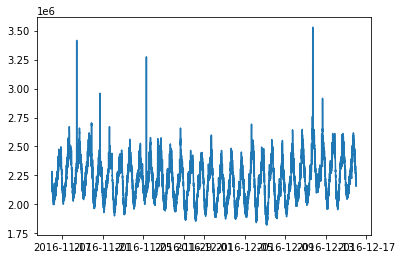

In [6]:
plt.plot(data["max cpu"])
plt.show()

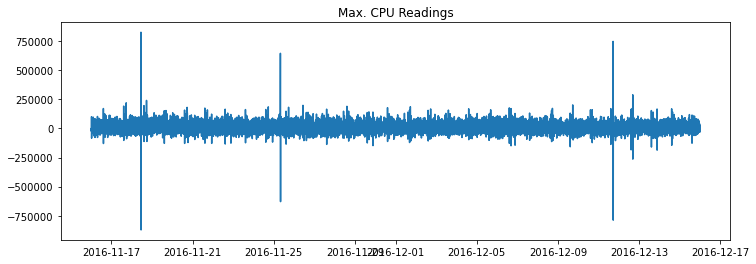

In [7]:
data = data.diff()
data = data.drop(data.head(1).index)

plt.figure(figsize=(12,4))
plt.plot(data["max cpu"])
plt.title("Max. CPU Readings")
plt.show()

# Rolling Window DataFrame
## Window: 48, (4 hours) two step ahead
CPU Readings (Maximum)

In [8]:
col_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14",
              "x15", "x16", "x17", "x18", "x19", "x20", "x21", "x22", "x23", "x24", "x25", "x26", "x27",
              "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40",
              "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [9]:
windows = 48

rw48_predictions = data.reset_index()

rw48_windows = pd.DataFrame([window.to_list() for window in data["max cpu"].rolling(window=windows+1)], 
                          columns =  col_names + ["extra"])

rw48_predictions = pd.merge(rw48_predictions, rw48_windows, left_index=True, right_index=True)
           
rw48_predictions.head()

,datetime,avg cpu,max cpu,x1,x2,x3,x4,x5,x6,x7,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,extra
0,2016-11-16 00:05:00,-18247.662562,-10909.187252,-10909.187252,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-11-16 00:10:00,-4686.794736,663.499454,-10909.187252,663.499454,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-11-16 00:15:00,-16266.407090,-25484.505811,-10909.187252,663.499454,-25484.505811,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-11-16 00:20:00,-9376.819149,-3887.753457,-10909.187252,663.499454,-25484.505811,-3887.753457,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-11-16 00:25:00,39297.268601,100597.082507,-10909.187252,663.499454,-25484.505811,-3887.753457,100597.082507,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
rw48_predictions = rw48_predictions.drop(rw48_predictions.head(windows+1).index) # drop first rows with NAN values

In [11]:
rw48_predictions = rw48_predictions[["datetime", "max cpu"] + col_names]

In [12]:
train, test = train_test_split(rw48_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6872, 50), (1718, 50))

# Normalise the data

In [14]:
scaler = MinMaxScaler()
train[["max cpu"] + col_names] = scaler.fit_transform(train[["max cpu"] + col_names])
test[["max cpu"] + col_names] = scaler.transform(test[["max cpu"] + col_names])

In [13]:
norm_max_cpu = pd.concat([train, test])
norm_max_cpu.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Normalised Data/max_cpu_reading_norm.csv")

In [15]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['max cpu'].values, test_size=0.2, random_state=42, shuffle=False)

In [16]:
x_train = train[col_names]
y_train = train["max cpu"]
x_test = test[col_names]
y_test = test["max cpu"]

# Prediction Models
Use two step ahead prediction: t1-t5 predict t7
shift all current preds by -1 and delete last row
### Baseline

In [17]:
test["baseline"] = test[["max cpu"]].shift(1) # for step ahead prediction
test = test.drop(test.head(1).index) # Drop first row as it has no baseline predictor
test.head()

,datetime,max cpu,x1,x2,x3,x4,x5,x6,x7,x8,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,baseline
6922,2016-12-10 00:55:00,0.535115,0.523196,0.487963,0.470000,0.505894,0.510908,0.480834,0.565887,0.504357,...,0.509640,0.507283,0.502306,0.559557,0.474628,0.527180,0.520046,0.496662,0.551383,0.551383
6923,2016-12-10 01:00:00,0.468960,0.487963,0.470000,0.505894,0.510908,0.480834,0.565887,0.504357,0.500448,...,0.507283,0.502306,0.559557,0.474628,0.527180,0.520046,0.496662,0.551383,0.535115,0.535115
6924,2016-12-10 01:05:00,0.486078,0.470000,0.505894,0.510908,0.480834,0.565887,0.504357,0.500448,0.498305,...,0.502306,0.559557,0.474628,0.527180,0.520046,0.496662,0.551383,0.535115,0.468960,0.468960
6925,2016-12-10 01:10:00,0.515249,0.505894,0.510908,0.480834,0.565887,0.504357,0.500448,0.498305,0.514159,...,0.559557,0.474628,0.527180,0.520046,0.496662,0.551383,0.535115,0.468960,0.486078,0.486078
6926,2016-12-10 01:15:00,0.495817,0.510908,0.480834,0.565887,0.504357,0.500448,0.498305,0.514159,0.507429,...,0.474628,0.527180,0.520046,0.496662,0.551383,0.535115,0.468960,0.486078,0.515249,0.515249


### Linear Regression

In [18]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.5794873363542625


In [19]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

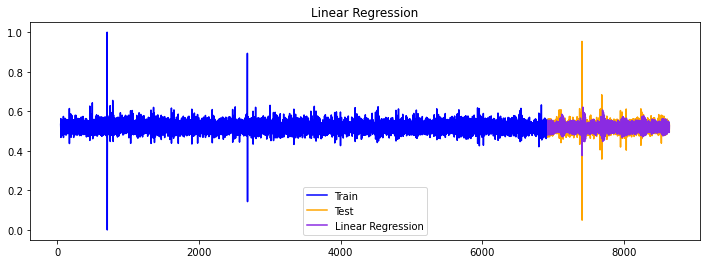

In [20]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [21]:
rw48_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["max cpu"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['max cpu'], test['baseline']))] })

In [22]:
lr_mape = mean_absolute_error(test["max cpu"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw48_results = pd.concat([rw48_results, lr_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012330,0.021340


### Decision Tree

In [23]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 5}
0.49276740183833856


In [29]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

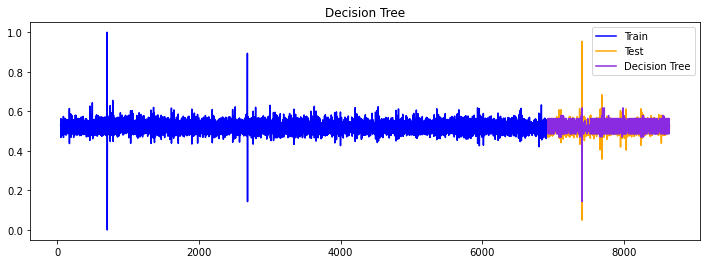

In [30]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [31]:
dt_mape = mean_absolute_error(test["max cpu"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw48_results = pd.concat([rw48_results, dt_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012330,0.021340
0,Decision Tree,0.012863,0.020374


### Random Forest

In [24]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.6097127583807807


In [32]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

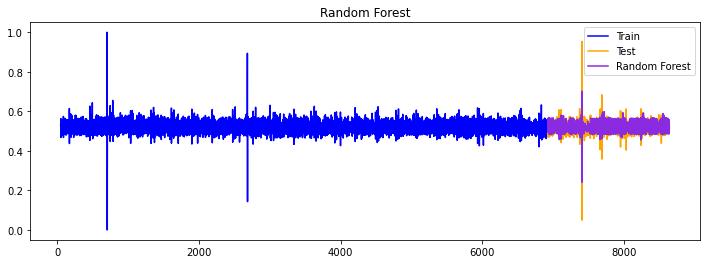

In [33]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [34]:
rf_mape = mean_absolute_error(test["max cpu"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw48_results = pd.concat([rw48_results, rf_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012330,0.021340
0,Decision Tree,0.012863,0.020374
0,Random Forest,0.011200,0.018964


### Gradient Boosting

In [25]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 5, 'n_estimators': 300}
0.6584659525806573


In [35]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=5, n_estimators=300, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

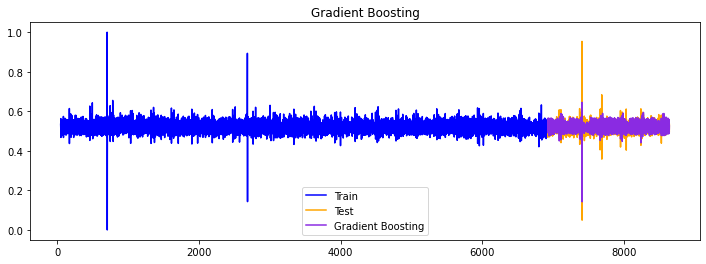

In [36]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [37]:
gb_mape = mean_absolute_error(test["max cpu"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw48_results = pd.concat([rw48_results, gb_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012330,0.021340
0,Decision Tree,0.012863,0.020374
0,Random Forest,0.011200,0.018964
0,Gradient Boosting,0.010541,0.017697


### KNN

In [26]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}
0.6604780788368351


In [38]:
knn_model = KNeighborsRegressor(algorithm='auto', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

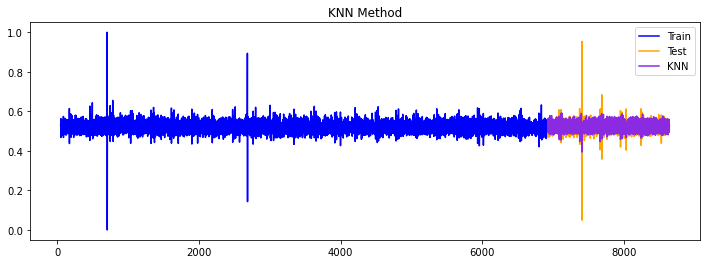

In [24]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [40]:
knn_mape = mean_absolute_error(test["max cpu"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw48_results = pd.concat([rw48_results, knn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012330,0.021340
0,Decision Tree,0.012863,0.020374
0,Random Forest,0.011200,0.018964
0,Gradient Boosting,0.010541,0.017697
0,KNN,0.010667,0.019518


### Neural Network

In [27]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'identity', 'hidden_layer_sizes': 150, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.567062314915732


In [41]:
nn_model = MLPRegressor(random_state=1, activation='identity', hidden_layer_sizes=150, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

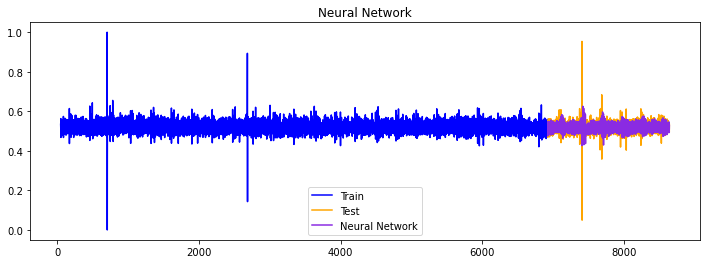

In [42]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [43]:
nn_mape = mean_absolute_error(test["max cpu"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw48_results = pd.concat([rw48_results, nn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012330,0.021340
0,Decision Tree,0.012863,0.020374
0,Random Forest,0.011200,0.018964
0,Gradient Boosting,0.010541,0.017697
0,KNN,0.010667,0.019518
0,Neural Network,0.012607,0.022152


### Simple Moving Average

In [28]:
test["sma_pred"] = test[col_names].mean(axis=1)[1:]+[0]

In [44]:
test = test.drop(test.head(1).index) # Drop last row

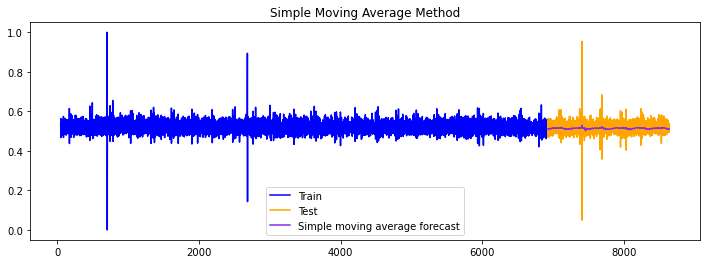

In [46]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [47]:
sma_mape = mean_absolute_error(test["max cpu"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw48_results = pd.concat([rw48_results, sma_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012330,0.021340
0,Decision Tree,0.012863,0.020374
0,Random Forest,0.011200,0.018964
0,Gradient Boosting,0.010541,0.017697
0,KNN,0.010667,0.019518
0,Neural Network,0.012607,0.022152
0,Simple Moving Avg.,0.018036,0.028788


## Window: 24 (2 hours)

In [13]:
window = 24

rw24_predictions = rw48_predictions[["datetime", "max cpu", "x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32",
                                    "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw24_predictions.head()

,datetime,max cpu,x25,x26,x27,x28,x29,x30,x31,x32,...,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,34933.670034,-11213.050346,-19169.073015,-44466.418856,96646.161360,-43310.190827,-1652.211147,-21762.059977,-31422.196767,...,-16930.923530,63330.375811,-65611.854394,-7310.464703,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458
50,2016-11-16 04:15:00,15828.684031,-19169.073015,-44466.418856,96646.161360,-43310.190827,-1652.211147,-21762.059977,-31422.196767,-27044.500856,...,63330.375811,-65611.854394,-7310.464703,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458,34933.670034
51,2016-11-16 04:20:00,-3602.688694,-44466.418856,96646.161360,-43310.190827,-1652.211147,-21762.059977,-31422.196767,-27044.500856,49231.389531,...,-65611.854394,-7310.464703,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458,34933.670034,15828.684031
52,2016-11-16 04:25:00,84096.610157,96646.161360,-43310.190827,-1652.211147,-21762.059977,-31422.196767,-27044.500856,49231.389531,-26263.950003,...,-7310.464703,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458,34933.670034,15828.684031,-3602.688694
53,2016-11-16 04:30:00,-77722.170012,-43310.190827,-1652.211147,-21762.059977,-31422.196767,-27044.500856,49231.389531,-26263.950003,11820.810914,...,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458,34933.670034,15828.684031,-3602.688694,84096.610157


In [14]:
train, test = train_test_split(rw24_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6872, 26), (1718, 26))

# Normalise the data

In [15]:
col_names = ["x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40","x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [16]:
scaler = MinMaxScaler()
train[["max cpu"] + col_names] = scaler.fit_transform(train[["max cpu"] + col_names])
test[["max cpu"] + col_names] = scaler.transform(test[["max cpu"] + col_names])

In [17]:
x_train = train[col_names]
y_train = train["max cpu"]
x_test = test[col_names]
y_test = test["max cpu"]

# Prediction Models
Use two step ahead prediction: t1-t5 predict t7
shift all current preds by -1 and delete last row
### Baseline

In [18]:
test["baseline"] = test[["max cpu"]].shift(1)
test = test.drop(test.head(1).index)
test.head()

,datetime,max cpu,x25,x26,x27,x28,x29,x30,x31,x32,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,baseline
6922,2016-12-10 00:55:00,0.535115,0.524756,0.462273,0.499460,0.519949,0.512288,0.504360,0.545655,0.482566,...,0.509640,0.507283,0.502306,0.559557,0.474628,0.527180,0.520046,0.496662,0.551383,0.551383
6923,2016-12-10 01:00:00,0.468960,0.462273,0.499460,0.519949,0.512288,0.504360,0.545655,0.482566,0.507859,...,0.507283,0.502306,0.559557,0.474628,0.527180,0.520046,0.496662,0.551383,0.535115,0.535115
6924,2016-12-10 01:05:00,0.486078,0.499460,0.519949,0.512288,0.504360,0.545655,0.482566,0.507859,0.524409,...,0.502306,0.559557,0.474628,0.527180,0.520046,0.496662,0.551383,0.535115,0.468960,0.468960
6925,2016-12-10 01:10:00,0.515249,0.519949,0.512288,0.504360,0.545655,0.482566,0.507859,0.524409,0.508851,...,0.559557,0.474628,0.527180,0.520046,0.496662,0.551383,0.535115,0.468960,0.486078,0.486078
6926,2016-12-10 01:15:00,0.495817,0.512288,0.504360,0.545655,0.482566,0.507859,0.524409,0.508851,0.501204,...,0.474628,0.527180,0.520046,0.496662,0.551383,0.535115,0.468960,0.486078,0.515249,0.515249


### Linear Regression

In [54]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.5530005690448936


In [55]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

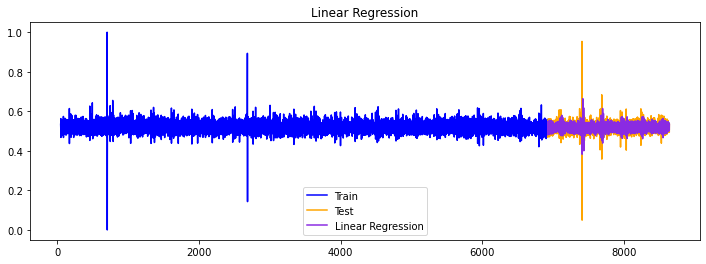

In [56]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [57]:
rw24_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["max cpu"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['max cpu'], test['baseline']))] })

In [58]:
lr_mape = mean_absolute_error(test["max cpu"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw24_results = pd.concat([rw24_results, lr_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012478,0.021937


### Decision Tree

In [59]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 5}
0.4860980331970987


In [65]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

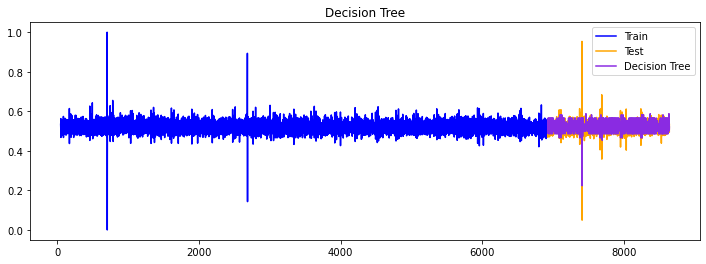

In [66]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [67]:
dt_mape = mean_absolute_error(test["max cpu"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw24_results = pd.concat([rw24_results, dt_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012478,0.021937
0,Decision Tree,0.012949,0.020865


### Random Forest

In [60]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.5866074091892843


In [19]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

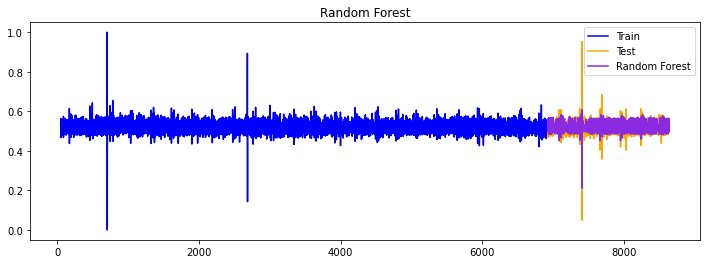

In [20]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

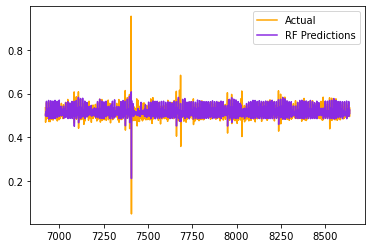

In [21]:
plt.figure(figsize=(6,4))
plt.plot(test['max cpu'], label='Actual', color="orange")
plt.plot(test['rf_pred'], label='RF Predictions', color="blueviolet")
plt.legend(loc='best')
plt.show()

In [70]:
rf_mape = mean_absolute_error(test["max cpu"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw24_results = pd.concat([rw24_results, rf_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012478,0.021937
0,Decision Tree,0.012949,0.020865
0,Random Forest,0.011360,0.018992


### Gradient Boosting

In [61]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 5, 'n_estimators': 200}
0.6351105176694392


In [71]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=5, n_estimators=200, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

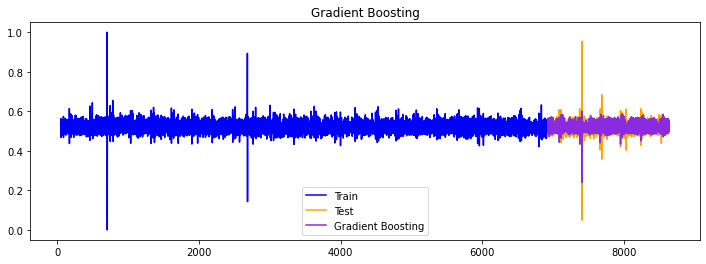

In [72]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [73]:
gb_mape = mean_absolute_error(test["max cpu"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw24_results = pd.concat([rw24_results, gb_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012478,0.021937
0,Decision Tree,0.012949,0.020865
0,Random Forest,0.011360,0.018992
0,Gradient Boosting,0.011097,0.019138


### KNN

In [62]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}
0.6505841493224848


In [22]:
knn_model = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

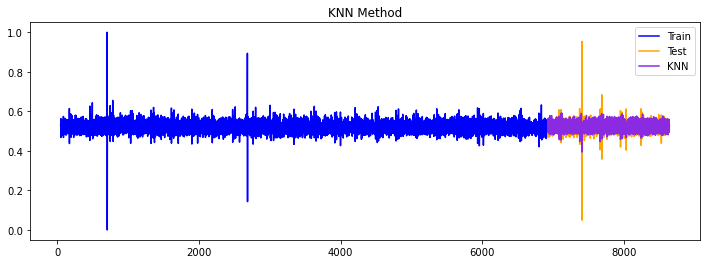

In [23]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

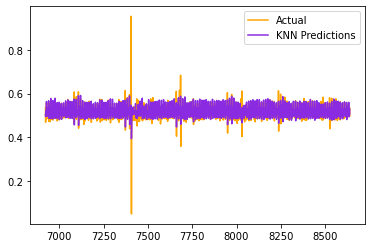

In [26]:
plt.figure(figsize=(6,4))
plt.plot(test['max cpu'], label='Actual', color="orange")
plt.plot(test['knn_pred'], label='KNN Predictions', color="blueviolet")
plt.legend(loc='best')
plt.show()

In [76]:
knn_mape = mean_absolute_error(test["max cpu"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw24_results = pd.concat([rw24_results, knn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012478,0.021937
0,Decision Tree,0.012949,0.020865
0,Random Forest,0.011360,0.018992
0,Gradient Boosting,0.011097,0.019138
0,KNN,0.010897,0.019552


### Neural Network

In [63]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.5097959576189619


In [77]:
nn_model = MLPRegressor(random_state=1, activation='identity', hidden_layer_sizes=100, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

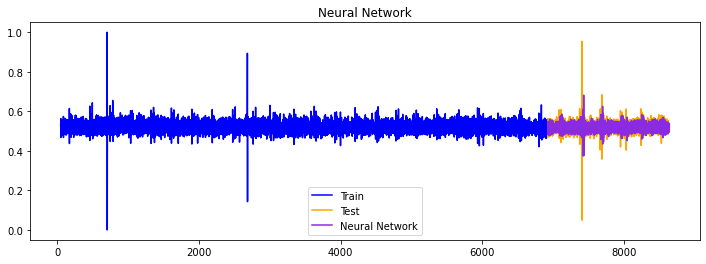

In [78]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [79]:
nn_mape = mean_absolute_error(test["max cpu"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw24_results = pd.concat([rw24_results, nn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012478,0.021937
0,Decision Tree,0.012949,0.020865
0,Random Forest,0.011360,0.018992
0,Gradient Boosting,0.011097,0.019138
0,KNN,0.010897,0.019552
0,Neural Network,0.013415,0.023868


### Simple Moving Average

In [64]:
test["sma_pred"] = test[col_names].mean(axis=1)[1:]+[0]

In [80]:
test = test.drop(test.head(1).index) # Drop last row

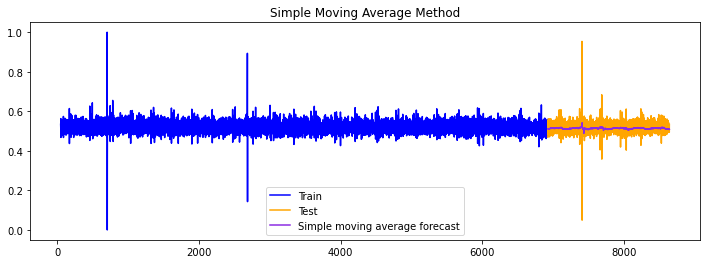

In [81]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [82]:
sma_mape = mean_absolute_error(test["max cpu"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw24_results = pd.concat([rw24_results, sma_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.012478,0.021937
0,Decision Tree,0.012949,0.020865
0,Random Forest,0.011360,0.018992
0,Gradient Boosting,0.011097,0.019138
0,KNN,0.010897,0.019552
0,Neural Network,0.013415,0.023868
0,Simple Moving Avg.,0.018132,0.028962


## Window: 12 (1 hour)

In [27]:
col_names = ["x37", "x38", "x39", "x40", "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [28]:
window = 12

rw12_predictions = rw48_predictions[["datetime", "max cpu", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw12_predictions.head()

,datetime,max cpu,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,34933.670034,24545.965862,-36509.740398,-16930.923530,63330.375811,-65611.854394,-7310.464703,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458
50,2016-11-16 04:15:00,15828.684031,-36509.740398,-16930.923530,63330.375811,-65611.854394,-7310.464703,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458,34933.670034
51,2016-11-16 04:20:00,-3602.688694,-16930.923530,63330.375811,-65611.854394,-7310.464703,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458,34933.670034,15828.684031
52,2016-11-16 04:25:00,84096.610157,63330.375811,-65611.854394,-7310.464703,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458,34933.670034,15828.684031,-3602.688694
53,2016-11-16 04:30:00,-77722.170012,-65611.854394,-7310.464703,-471.220420,-11556.958895,-13826.270696,35520.651281,-19034.503927,1093.470458,34933.670034,15828.684031,-3602.688694,84096.610157


In [29]:
train, test = train_test_split(rw12_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6872, 14), (1718, 14))

# Normalise the data

In [30]:
scaler = MinMaxScaler()
train[["max cpu"] + col_names] = scaler.fit_transform(train[["max cpu"] + col_names])
test[["max cpu"] + col_names] = scaler.transform(test[["max cpu"] + col_names])

In [31]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['max cpu'].values, test_size=0.2, random_state=42, shuffle=False)

In [32]:
x_train = train[col_names]
y_train = train["max cpu"]
x_test = test[col_names]
y_test = test["max cpu"]

# Prediction Models
Use two step ahead prediction: t1-t5 predict t7
shift all current preds by -1 and delete last row
### Baseline

In [33]:
test["baseline"] = test[["max cpu"]].shift(1) # for step ahead prediction
test = test.drop(test.head(1).index) # Drop first row as it has no baseline predictor

### Linear Regression

In [90]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.4756745567698813


In [91]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

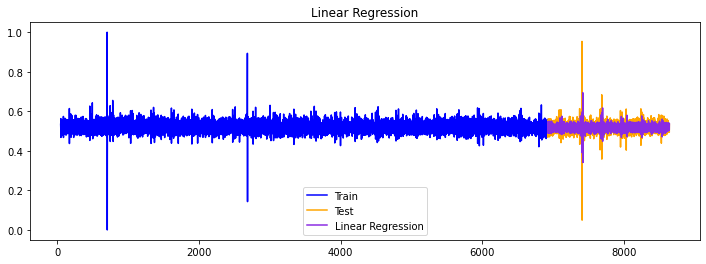

In [92]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [93]:
rw12_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["max cpu"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['max cpu'], test['baseline']))] })

In [94]:
lr_mape = mean_absolute_error(test["max cpu"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw12_results = pd.concat([rw12_results, lr_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.013419,0.023290


### Decision Tree

In [95]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 5}
0.47728613530798514


In [101]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

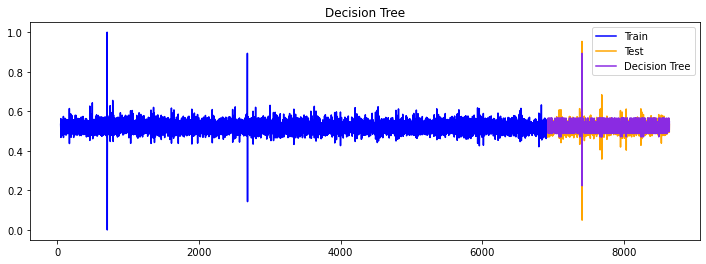

In [102]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [103]:
dt_mape = mean_absolute_error(test["max cpu"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw12_results = pd.concat([rw12_results, dt_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.013419,0.023290
0,Decision Tree,0.013236,0.021586


### Random Forest

In [96]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.5497362634006092


In [34]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

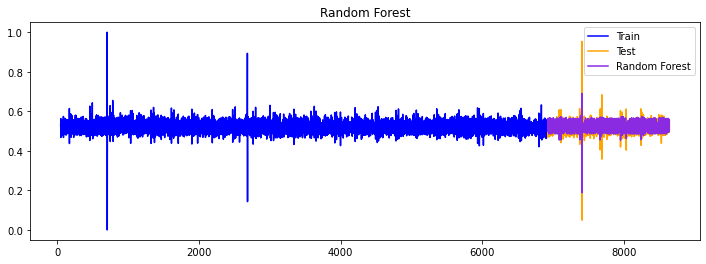

In [35]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

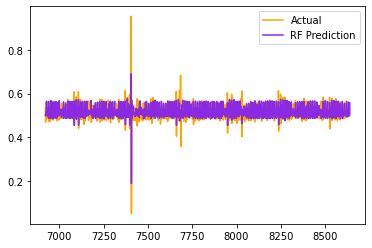

In [36]:
plt.figure(figsize=(6,4))
plt.plot(test['max cpu'], label='Actual', color="orange")
plt.plot(test['rf_pred'], label='RF Prediction', color="blueviolet")
plt.legend(loc='best')
plt.show()

In [106]:
rf_mape = mean_absolute_error(test["max cpu"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw12_results = pd.concat([rw12_results, rf_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.013419,0.023290
0,Decision Tree,0.013236,0.021586
0,Random Forest,0.011926,0.019806


### Gradient Boosting

In [97]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 5, 'n_estimators': 200}
0.5924691616444421


In [107]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=5, n_estimators=200, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

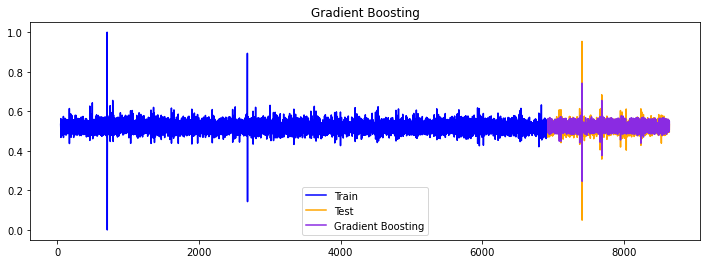

In [108]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [109]:
gb_mape = mean_absolute_error(test["max cpu"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw12_results = pd.concat([rw12_results, gb_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.013419,0.023290
0,Decision Tree,0.013236,0.021586
0,Random Forest,0.011926,0.019806
0,Gradient Boosting,0.011819,0.020936


### KNN

In [98]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'distance'}
0.6232750950516077


In [110]:
knn_model = KNeighborsRegressor(algorithm='brute', n_neighbors=10, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

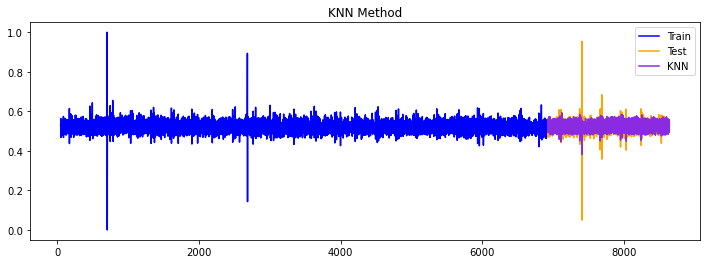

In [111]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [112]:
knn_mape = mean_absolute_error(test["max cpu"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw12_results = pd.concat([rw12_results, knn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.013419,0.023290
0,Decision Tree,0.013236,0.021586
0,Random Forest,0.011926,0.019806
0,Gradient Boosting,0.011819,0.020936
0,KNN,0.011187,0.020026


### Neural Network

In [99]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'identity', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.46705733026472007


In [113]:
nn_model = MLPRegressor(random_state=1, activation='identity', hidden_layer_sizes=100, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

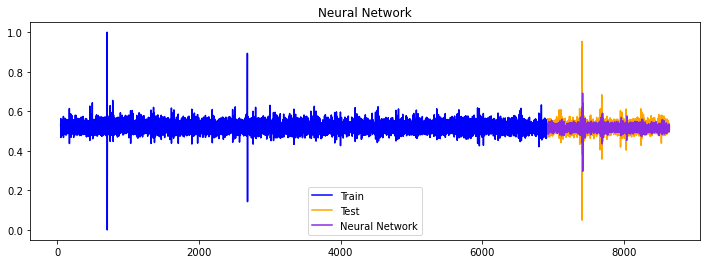

In [114]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [115]:
nn_mape = mean_absolute_error(test["max cpu"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw12_results = pd.concat([rw12_results, nn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.013419,0.023290
0,Decision Tree,0.013236,0.021586
0,Random Forest,0.011926,0.019806
0,Gradient Boosting,0.011819,0.020936
0,KNN,0.011187,0.020026
0,Neural Network,0.015983,0.026901


### Simple Moving Average

In [100]:
test["sma_pred"] = test[col_names].mean(axis=1)[1:] +[0]

In [116]:
test = test.drop(test.head(1).index) # Drop last row

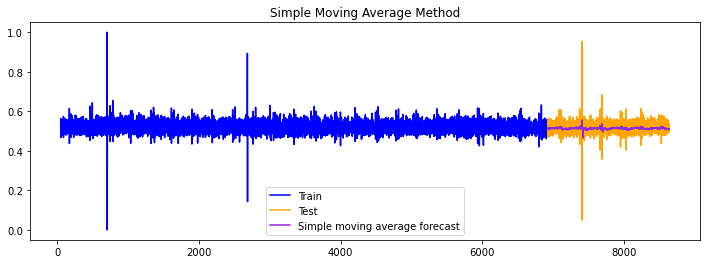

In [117]:
plt.figure(figsize=(12,4))
plt.plot(train['max cpu'], label='Train', color="b")
plt.plot(test['max cpu'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [118]:
sma_mape = mean_absolute_error(test["max cpu"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['max cpu'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw12_results = pd.concat([rw12_results, sma_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.029431,0.044461
0,Linear Regression,0.013419,0.023290
0,Decision Tree,0.013236,0.021586
0,Random Forest,0.011926,0.019806
0,Gradient Boosting,0.011819,0.020936
0,KNN,0.011187,0.020026
0,Neural Network,0.015983,0.026901
0,Simple Moving Avg.,0.018320,0.029341


# Result Comparision

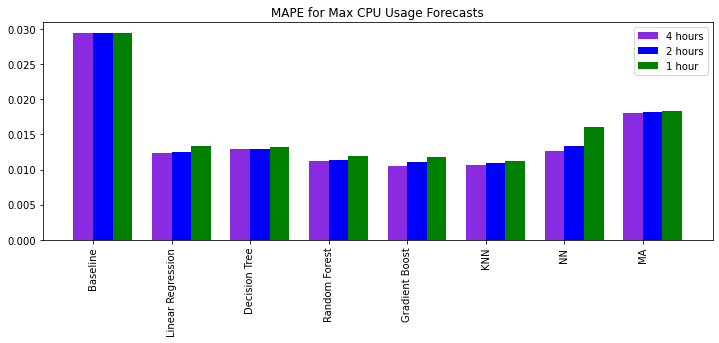

In [119]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["MAE"], width=width, label="4 hours", color="blueviolet")
plt.bar(r+width, rw24_results["MAE"], width=width,  label="2 hours", color="b")
plt.bar(r+width+width, rw12_results["MAE"], width=width, label="1 hour", color="g")
plt.legend()
plt.title("MAPE for Max CPU Usage Forecasts")
plt.xticks(r + width/2,['Baseline', 'Linear Regression','Decision Tree','Random Forest','Gradient Boost', 'KNN','NN', 'MA'], rotation=90)
plt.show()

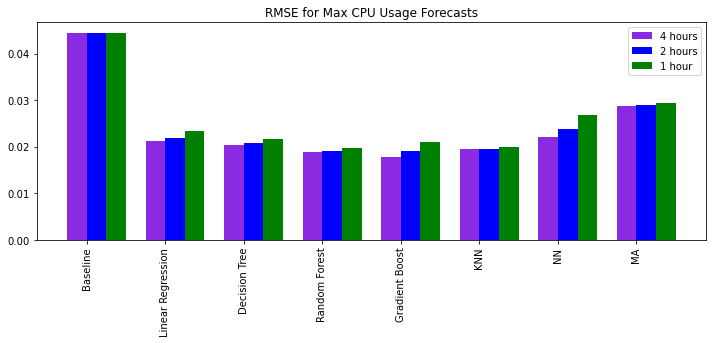

In [120]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["RMSE"], width=width, label="4 hours", color="blueviolet")
plt.bar(r+width, rw24_results["RMSE"], width=width, label="2 hours", color="b")
plt.bar(r+width+width, rw12_results["RMSE"], width=width, label="1 hour", color="g")
plt.legend()
plt.title("RMSE for Max CPU Usage Forecasts")
plt.xticks(r + width/2,['Baseline', 'Linear Regression','Decision Tree','Random Forest','Gradient Boost', 'KNN','NN', 'MA'], rotation=90)
plt.show()

In [121]:
rw48_results = rw48_results.reset_index()
rw24_results = rw24_results.reset_index()
rw12_results = rw12_results.reset_index()

In [122]:
total_results = pd.merge(rw48_results, rw24_results, on='Method', how='outer')
total_results = pd.merge(total_results, rw12_results, on='Method', how='outer')
total_results.head()

,index_x,Method,MAE_x,RMSE_x,index_y,MAE_y,RMSE_y,index,MAE,RMSE
0,0,Baseline,0.029431,0.044461,0,0.029431,0.044461,0,0.029431,0.044461
1,0,Linear Regression,0.012330,0.021340,0,0.012478,0.021937,0,0.013419,0.023290
2,0,Decision Tree,0.012863,0.020374,0,0.012949,0.020865,0,0.013236,0.021586
3,0,Random Forest,0.011200,0.018964,0,0.011360,0.018992,0,0.011926,0.019806
4,0,Gradient Boosting,0.010541,0.017697,0,0.011097,0.019138,0,0.011819,0.020936


In [123]:
total_results = total_results[["Method","MAE_x", "RMSE_x", "MAE_y", "RMSE_y", "MAE", "RMSE"]]

In [124]:
total_results = total_results.rename(columns={total_results.columns[0]: "Methods", 
                              total_results.columns[1]: "MAE (w=48)", total_results.columns[2]: "RMSE (w=48)", 
                              total_results.columns[3]: "MAE (w=24)", total_results.columns[4]: "RMSE (w=24)", 
                              total_results.columns[5]: "MAE (w=12)", total_results.columns[6]: "RMSE (w=12)", 
                            })

In [125]:
total_results.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Results/max_cpu_readings_results.csv")